<a href="https://colab.research.google.com/github/ggandyt/StillWork_Team_5/blob/main/team_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

팀 프로젝트를 위한 노트북입니다. 이하 문제정의서 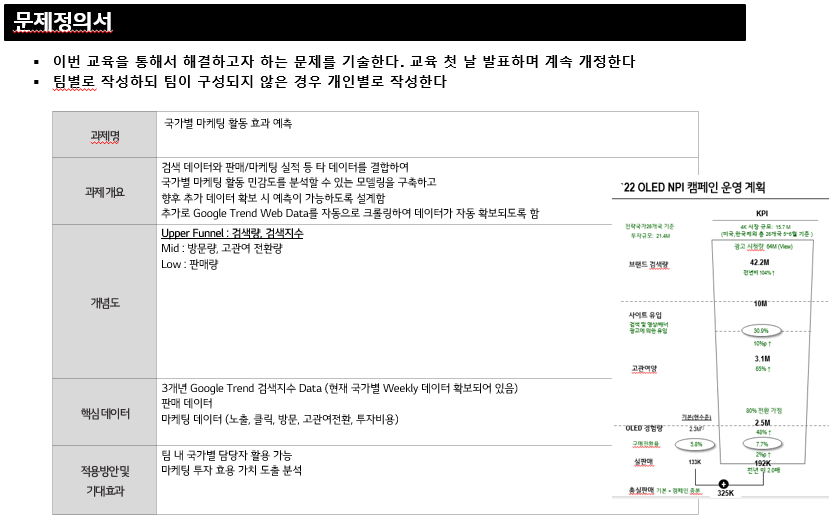

**2/16일 교육 시간에 논의된 내용**

5조 요약
- 국가단위로 보면 데이터 충분하지 않다.
- 국가별 마케팅 했을 때, 검색량, 판매 set out의 민감도 해보자
- 향후에 투자를 계속 이어갈 수 있을 거니까, 

목적 데이터 :
검색 지수, 판매
랜덤포레스트 쓰면 됨
1 hot 인코딩
입력변수는 다양하게 잘 골라야 한다.
국가는 그룹핑(클러스터링), 성격이 비슷한 국가를 묶어야함.
선진국/후진국, or 10개정도 클러스터링, 비 많이 오는 국가/ 아닌국가

# 과제 (WIP)
* 필요한 틀을 잡는 상황입니다. 수행되지 않아요 (2/17일)

## Import

In [155]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8,6)
matplotlib.rcParams.update({'font.size': 10})

In [156]:
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVC, SVR
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn import tree
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error,r2_score               
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import cross_validate

## 코랩에 한글 폰트 설치
- (주의!) 아래 셀을 한 번 실행 후에, 런타임 - 런타임 다시 시작을 실행하고 아래 셀을 한번 더 실행하여야 한다

In [157]:
#import matplotlib as mpl
#import matplotlib.pyplot as plt
#import matplotlib.font_manager as fm
 
#!apt -qq -y install fonts-nanum
 
#fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
#font = fm.FontProperties(fname=fontpath, size=10)
#plt.rc('font', family='NanumBarunGothic') 
#mpl.font_manager._rebuild()

### 한글 설정

In [158]:
import platform, matplotlib
from matplotlib import rc

matplotlib.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Windows':
    rc('font', family="Malgun Gothic")
elif platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Linux':
    rc('font', family='NanumBarunGothic')

## 테이타 파일을 읽기

In [159]:
# CSV 파일은 utf-8 기준으로 저장되어야 한글이 정상적으로 처리됩니다.
data = pd.read_csv('https://github.com/dreamer0710/StillWork_Team_5/raw/main/Team_5_data.csv')
print(data.shape)
print(data.head())
print(data.keys())
data.info()

(9736, 37)
   YEAR  MONTH  Q   Region         법인    COUNTRY 성숙도    기간1    기간2       미디어  \
0  2019      1  1  Oceania  Australia  Australia  성숙  캠페인이전  캠페인이전  No media   
1  2019      1  1  Oceania  Australia  Australia  성숙  캠페인이전  캠페인이전  No media   
2  2019      1  1  Oceania  Australia  Australia  성숙  캠페인이전  캠페인이전  No media   
3  2019      1  1  Oceania  Australia  Australia  성숙  캠페인이전  캠페인이전  No media   
4  2019      2  1  Oceania  Australia  Australia  성숙  캠페인이전  캠페인이전  No media   

   ... GRP_High BM Comp_GRP  Sell-out  selout_remarks        Week QLED  \
0  ...         NaN      NaN       1802            NaN  2019-01-06  8.0   
1  ...         NaN      NaN       1147            NaN  2019-01-13  4.0   
2  ...         NaN      NaN       1383            NaN  2019-01-20  4.0   
3  ...         NaN      NaN       1506            NaN  2019-01-27  5.0   
4  ...         NaN      NaN       1021            NaN  2019-02-03  4.0   

  LG OLED SONY OLED  OLED  4K  
0     7.0       1.0  19.0  76  

### 데이타 조정하기

*   국가(country) 그룹핑이 필요

참고: [d_23_Clusters.ipynb](https://colab.research.google.com/github/StillWork/HE_0216/blob/main/d_23_Clusters.ipynb#scrollTo=301baf6b)

In [160]:
df = data.copy() # 원본 복사에서 사용함
print(df.shape)


(9736, 37)


#### ' - ' 를 0으로 전환하기  
['Spending(M$)\n_Seeding'],	'Spending(M$)\n_SEM',	'Spending(M$)_Digital',	'WTB_Seeding',	'WTB_SEM',	'WTB' 열은 

In [161]:
#for index, row in df.iterrows():
#  print("'%s'" % row["Spending(M$)\n_Seeding"])
#print(f'"df['Spending(M$)\n_Seeding']")
#print(df[['Spending(M$)\n_Seeding', 'Spending(M$)\n_SEM', 'Spending(M$)_Digital']])
df[['Spending(M$)\n_Seeding', 'Spending(M$)\n_SEM', 'Spending(M$)_Digital']] = df[['Spending(M$)\n_Seeding','Spending(M$)\n_SEM', 'Spending(M$)_Digital']].replace(' - ',0.0)
# data 형태: 0.000 
df['Spending(M$)\n_Seeding'] = df['Spending(M$)\n_Seeding'].astype(float)
df['Spending(M$)\n_SEM'] = df['Spending(M$)\n_SEM'].astype(float)
df['Spending(M$)_Digital'] = df['Spending(M$)_Digital'].astype(float)

df[['WTB_Seeding', 'WTB_SEM', ' WTB ', ' OLED 검색량 TTL ', ' LG OLED 검색량 TTL ', ' LG OLED 검색량 Low ']] = df[['WTB_Seeding', 'WTB_SEM', ' WTB ', ' OLED 검색량 TTL ', ' LG OLED 검색량 TTL ', ' LG OLED 검색량 Low ']].replace(' - ',0)
#df[['WTB_Seeding', 'WTB_SEM', ' WTB ']] = df[['WTB_Seeding', 'WTB_SEM', ' WTB ']].replace(' - ',0)
# data 형태: "12,1243" 과 같이 ','가 있는 경우 변환이 필요함
df['WTB_Seeding'] = df['WTB_Seeding'].apply(lambda x: int(''.join(x.split(',')) if type(x) == str else x ))
df['WTB_SEM'] = df['WTB_SEM'].apply(lambda x: int(''.join(x.split(',')) if type(x) == str else x ))
df[' WTB '] = df[' WTB '].apply(lambda x: int(''.join(x.split(',')) if type(x) == str else x ))
df[' OLED 검색량 TTL '] = df[' OLED 검색량 TTL '].apply(lambda x: int(''.join(x.split(',')) if type(x) == str else x ))
df[' LG OLED 검색량 TTL '] = df[' LG OLED 검색량 TTL '].apply(lambda x: int(''.join(x.split(',')) if type(x) == str else x ))
df[' LG OLED 검색량 Low '] = df[' LG OLED 검색량 Low '].apply(lambda x: int(''.join(x.split(',')) if type(x) == str else x ))
#print (df[' WTB '][df[' WTB '].isnull()])


#### Z(TVC_GRP)가 AB(GRP_High_BM)보다 높으면 2, Z에 숫자는 있지만 AB보다 작으면 1, Z에 숫자가 없으면 0 으로 데이터 치환한다

In [162]:
#for index, row in df.iterrows():
#  if np.isnan(row['TVC_GRP']): 
#    print(index, "'%s'" % row['TVC_GRP'], type(row['TVC_GRP']), f"'{np.nan}'", f'{type(np.nan)}')
#df['TVC_GRP'] = df.loc[:, ('TVC_GRP', 'GRP_High BM')].apply(lambda x: 0 if np.isnan(x[0]) else 2 if x[0] > x[1] else 1, axis=1) 
df['TVC_GRP'] = df['TVC_GRP'].apply(lambda x: 0 if np.isnan(x) else 1) 
#for index, row in df.iterrows():
#  print("'%s'" % row['TVC_GRP'])

#### '기간1' 내용이 없는 데이타는 버린다.

In [163]:
df2 = df[df['기간1'].notnull()]
print(df2.shape)
df2 = df2[df2[' Sell-out '].notnull()]
print(df2.shape)

df2[' Sell-out '] = df2[' Sell-out '].apply(lambda x: int(''.join(x.split(',')) if type(x) == str else x ))

(8236, 37)
(7743, 37)


#### 성숙도와 기간1은 1 hot 인코딩을 한다.

In [164]:
df2['성숙도'].value_counts()
df2['기간1'].value_counts()
df2['기간2'].value_counts()
print(df2['TVC_GRP'].value_counts())
df2 = pd.get_dummies(df2, columns=["성숙도","기간1",'기간2','TVC_GRP'])
df2[:3]
print(df2.keys())

0    7573
1     170
Name: TVC_GRP, dtype: int64
Index(['YEAR', 'MONTH', 'Q', 'Region', '법인', 'COUNTRY', '미디어', '미디어2',
       'Spending(M$)\n_Seeding', 'Spending(M$)\n_SEM', 'Spending(M$)_Digital',
       'WTB_Seeding', 'WTB_SEM', ' WTB ', ' OLED 검색량 TTL ',
       ' LG OLED 검색량 TTL ', ' LG OLED 검색량 Low ', ' Seeding WTB Upper+Mid ',
       ' Seeding WTB Low ', ' SEM WTB Brand+Core ', ' SEM WTB Low ',
       'Comp_campaign', 'Spending(M$)_TVC', 'GRP_High BM', 'Comp_GRP',
       ' Sell-out ', 'selout_remarks', 'Week', 'QLED', 'LG OLED', 'SONY OLED',
       'OLED', '4K', '성숙도_미성숙', '성숙도_성숙', '성숙도_성숙진입', '기간1_캠페인', '기간1_캠페인+1w',
       '기간1_캠페인+2w', '기간1_캠페인+3w', '기간1_캠페인이전', '기간1_캠페인이후', '기간2_캠페인+이후',
       '기간2_캠페인이전', 'TVC_GRP_0', 'TVC_GRP_1'],
      dtype='object')


#### 'OLED카테고리지수', 'OLED경쟁지수' 열을 구성합니다.


*   분모라 0인 경우가 있어서 분자 분모에 최소값(0.1)을 더해서 처리합니다.



In [165]:
df2.loc[:,'OLED경쟁지수'] = df2.loc[:, ('LG OLED', 'QLED')].apply(lambda x: (x[0]+0.1) / (x[1]+0.1), axis=1)
print(df2['OLED경쟁지수'])
df2.loc[:,'OLED카테고리지수'] = df2.loc[:, ('OLED', '4K')].apply(lambda x: (x[0]+0.1) / (x[1]+0.1), axis=1)
print(df2['OLED카테고리지수'])
print(df2.keys())
df2.info()

0       0.876543
1       1.000000
2       1.487805
3       0.803922
4       1.000000
          ...   
9730    1.000000
9731    1.000000
9732    0.024390
9733    1.000000
9734    1.000000
Name: OLED경쟁지수, Length: 7743, dtype: float64
0       0.250986
1       0.232246
2       0.259897
3       0.180036
4       0.144385
          ...   
9730    0.002849
9731    0.092971
9732    0.002169
9733    0.078695
9734    0.092971
Name: OLED카테고리지수, Length: 7743, dtype: float64
Index(['YEAR', 'MONTH', 'Q', 'Region', '법인', 'COUNTRY', '미디어', '미디어2',
       'Spending(M$)\n_Seeding', 'Spending(M$)\n_SEM', 'Spending(M$)_Digital',
       'WTB_Seeding', 'WTB_SEM', ' WTB ', ' OLED 검색량 TTL ',
       ' LG OLED 검색량 TTL ', ' LG OLED 검색량 Low ', ' Seeding WTB Upper+Mid ',
       ' Seeding WTB Low ', ' SEM WTB Brand+Core ', ' SEM WTB Low ',
       'Comp_campaign', 'Spending(M$)_TVC', 'GRP_High BM', 'Comp_GRP',
       ' Sell-out ', 'selout_remarks', 'Week', 'QLED', 'LG OLED', 'SONY OLED',
       'OLED', '4K', '성숙도_미성숙

#### BOX Plot 확인하기 

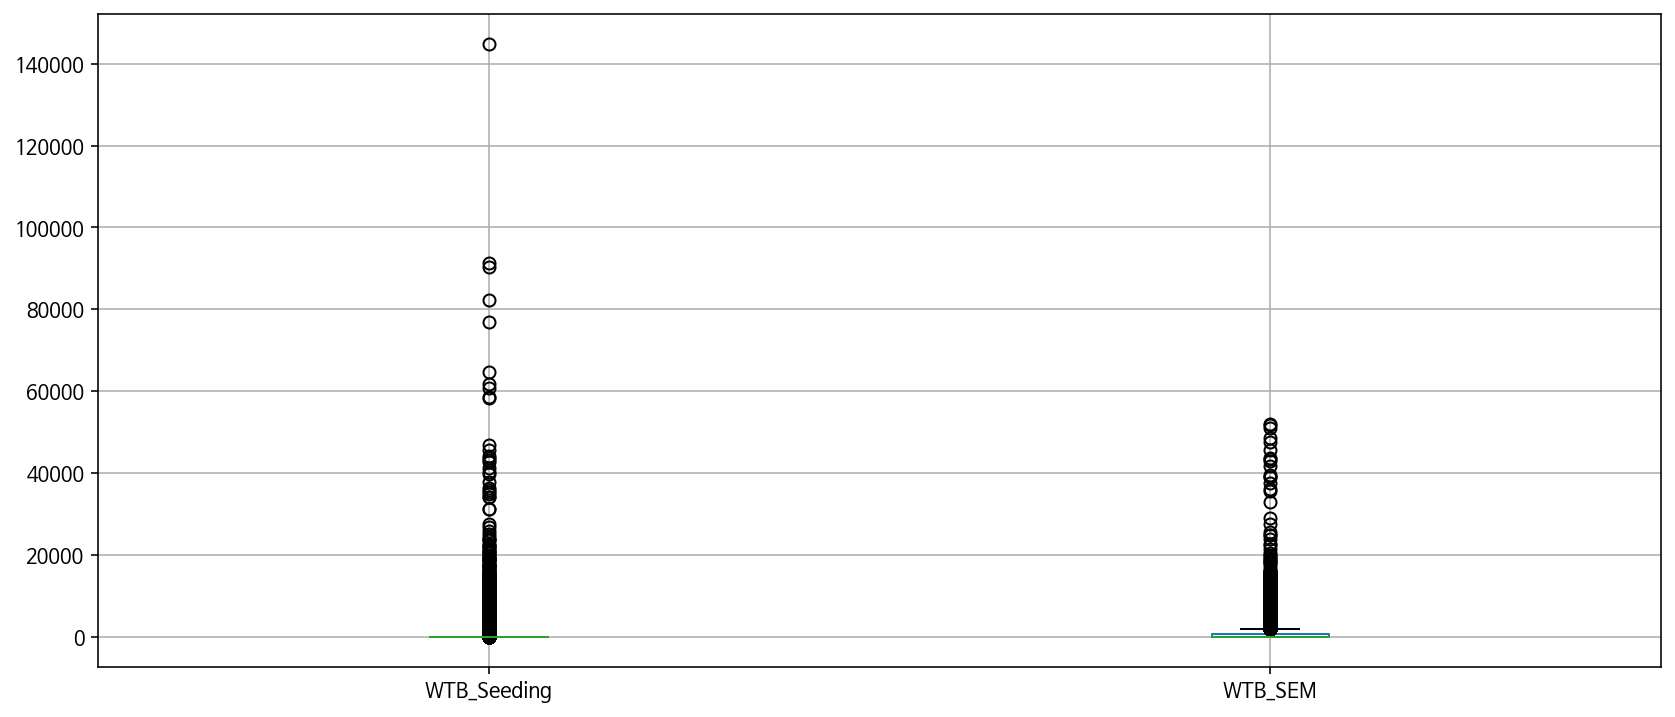

In [166]:
plt.figure(figsize=(14,6))
X[['WTB_Seeding', 'WTB_SEM']].boxplot()
plt.show()


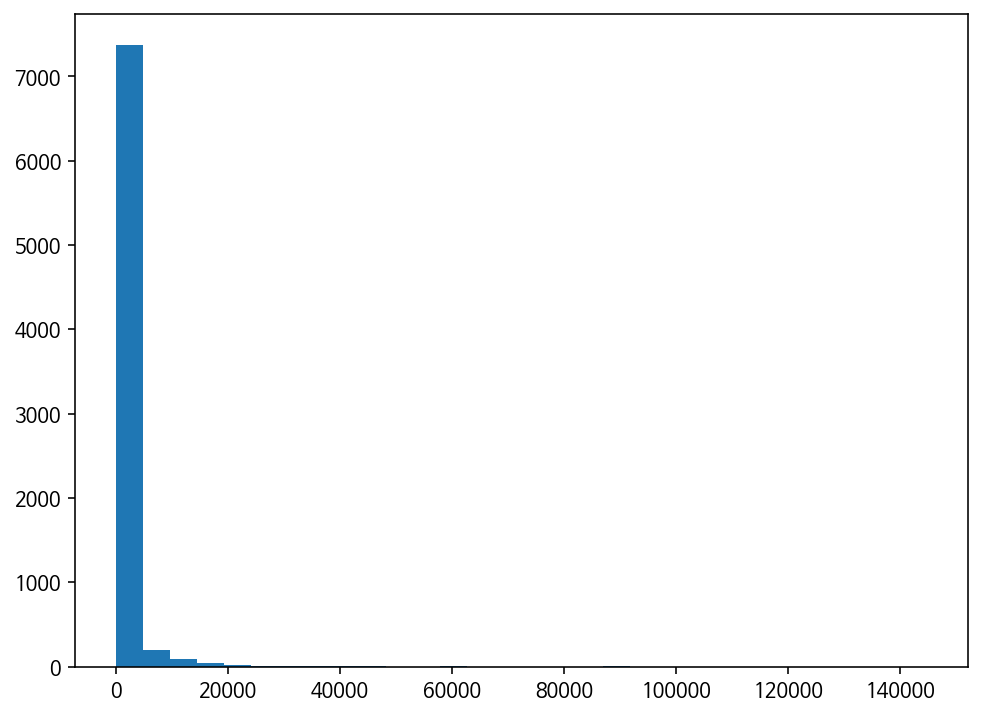

In [167]:
plt.hist(X['WTB_Seeding'], bins=30); plt.show()

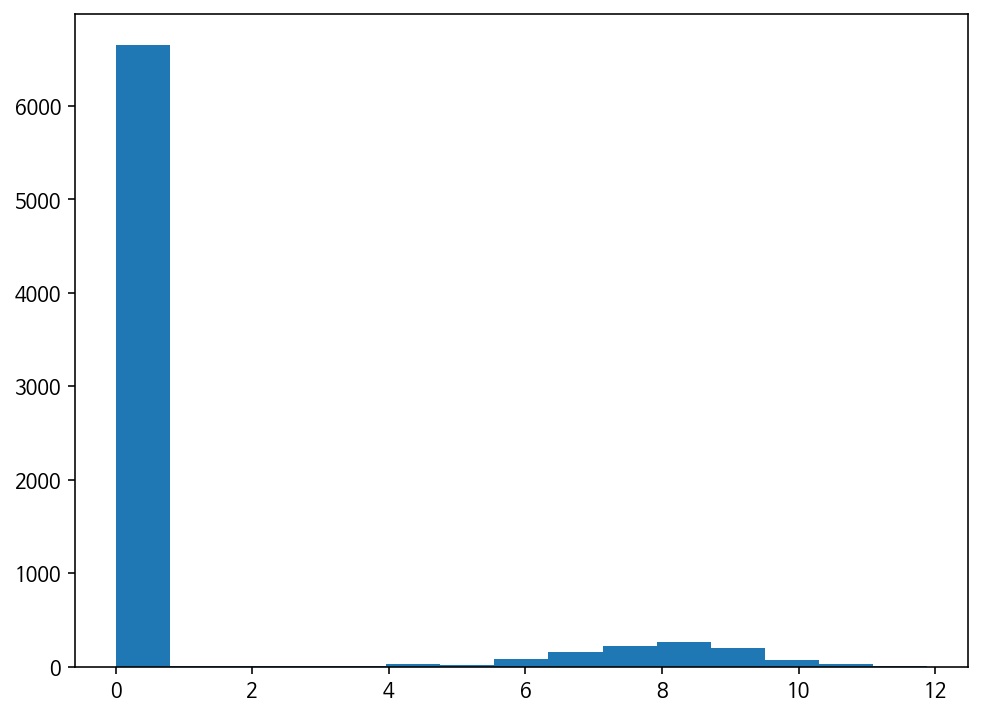

In [168]:
# 돈과 관련된 값은 로그변환을 하여 선형적인 값으로 변환하는 경우가 많다
# 로그를 취하면 정규 분포처럼 보인다 (log-normal 분포)
plt.hist(np.log(X['WTB_Seeding']+1), bins=15); plt.show()

In [169]:
X.loc[:]['WTB_Seeding'] = np.log(X['WTB_Seeding'] +1)
X.loc[:]['WTB_SEM'] = np.log(X['WTB_SEM'] +1)

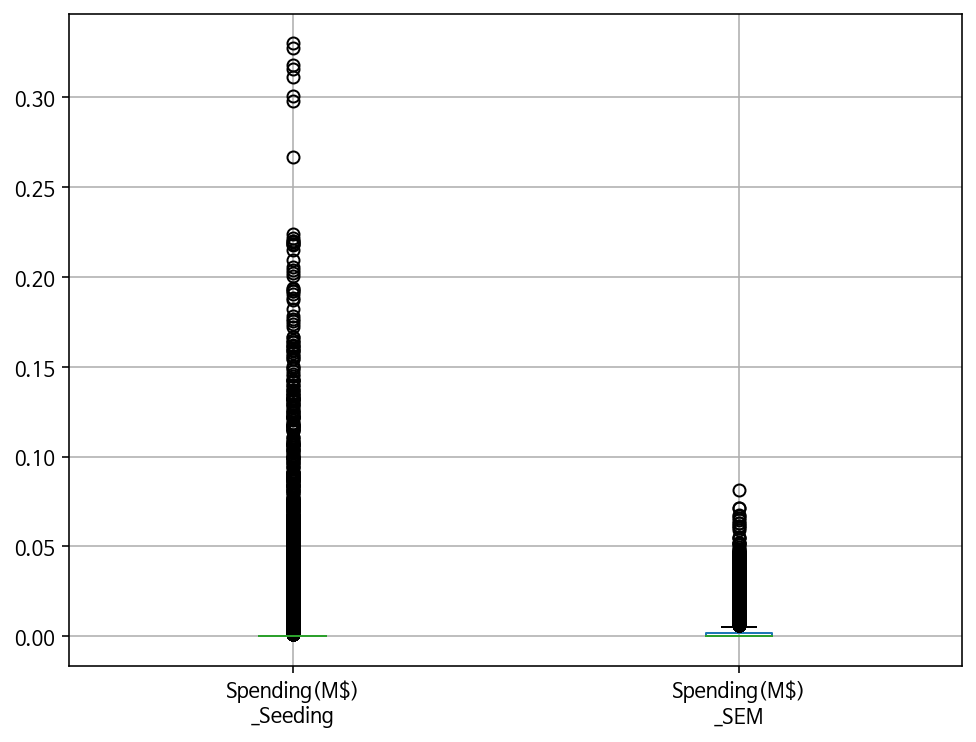

In [175]:
X[['Spending(M$)\n_Seeding', 'Spending(M$)\n_SEM']].boxplot()
plt.show()

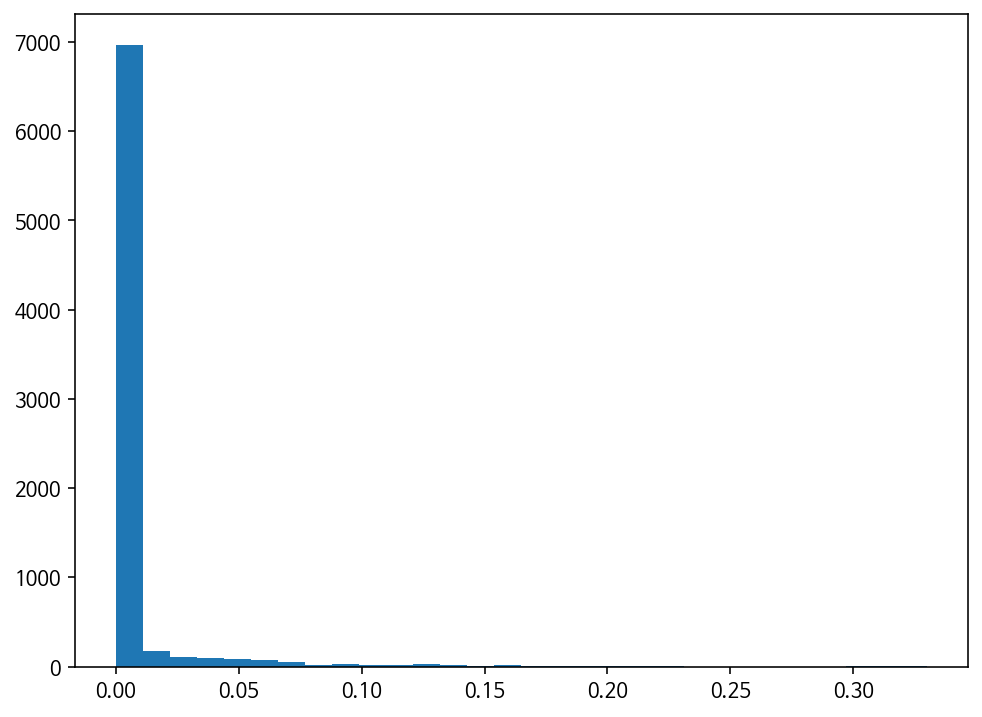

In [176]:
plt.hist(X['Spending(M$)\n_Seeding'], bins=30); plt.show()

In [ ]:
# 돈과 관련된 값은 로그변환을 하여 선형적인 값으로 변환하는 경우가 많다
# 로그를 취하면 정규 분포처럼 보인다 (log-normal 분포)
plt.hist(np.log(X['Spending(M$)\n_Seeding']+1), bins=15); plt.show()

In [178]:
X.loc[:]['Spending(M$)\n_Seeding'] = np.log(X['Spending(M$)\n_Seeding'] +1)
X.loc[:]['Spending(M$)\n_SEM'] = np.log(X['Spending(M$)\n_SEM'] +1)

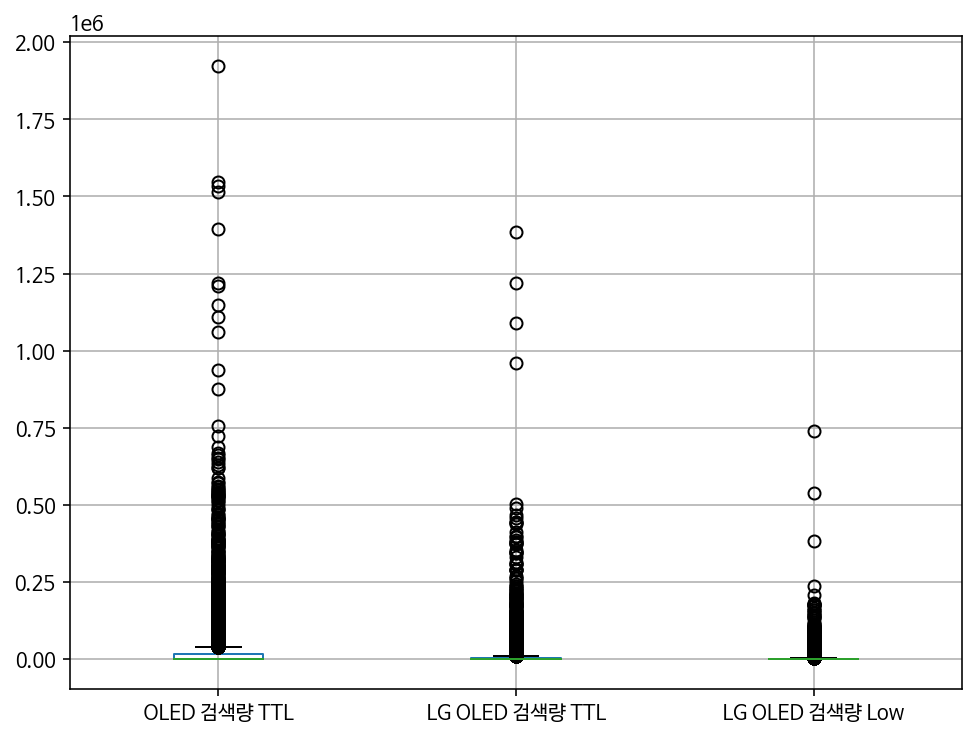

In [179]:
X[[' OLED 검색량 TTL ', ' LG OLED 검색량 TTL ', ' LG OLED 검색량 Low ']].boxplot()
plt.show()

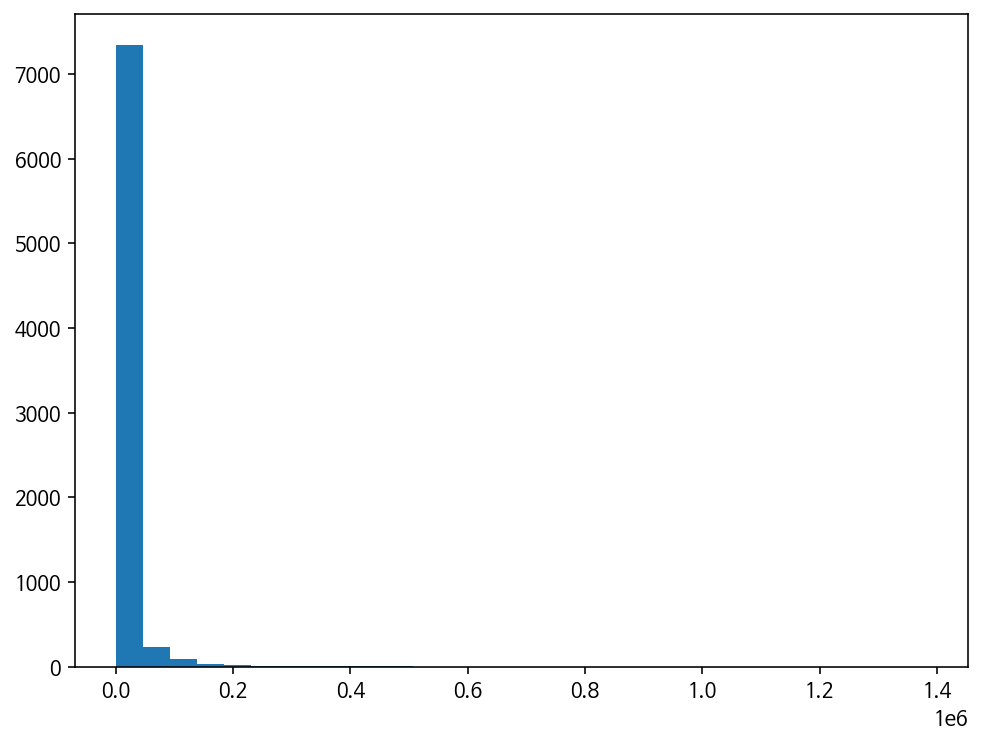

In [180]:
plt.hist(X[' LG OLED 검색량 TTL '], bins=30); plt.show()

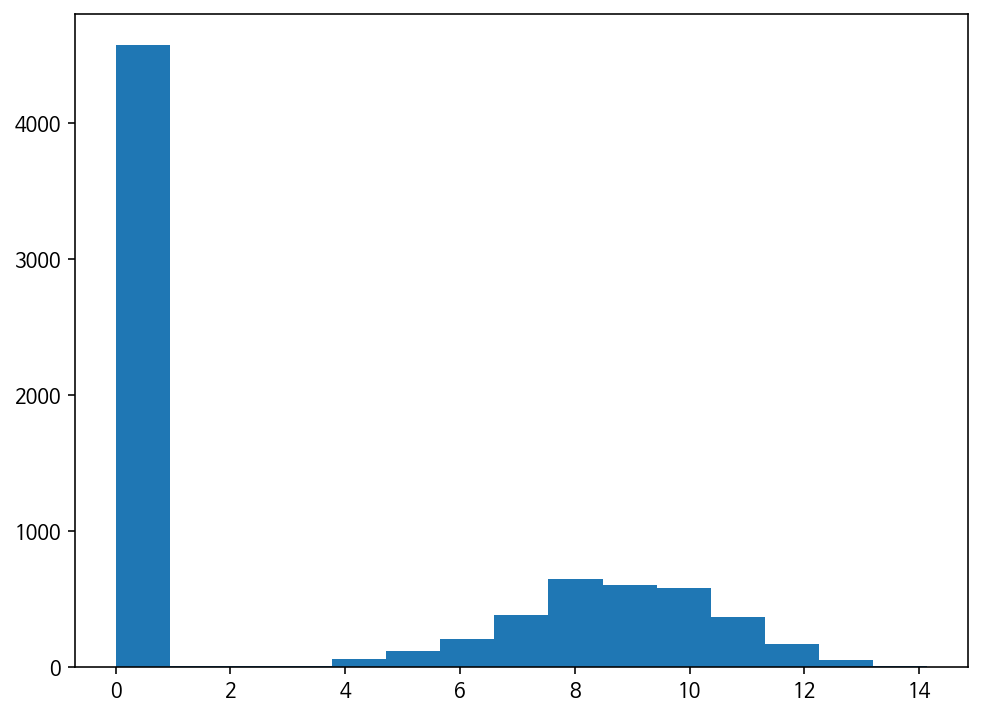

In [181]:
# 돈과 관련된 값은 로그변환을 하여 선형적인 값으로 변환하는 경우가 많다
# 로그를 취하면 정규 분포처럼 보인다 (log-normal 분포)
plt.hist(np.log(X[' LG OLED 검색량 TTL ']+1), bins=15); plt.show()

In [182]:
X.loc[:][' OLED 검색량 TTL '] = np.log(X[' OLED 검색량 TTL '] +1)
X.loc[:][' LG OLED 검색량 TTL '] = np.log(X[' LG OLED 검색량 TTL '] +1)
X.loc[:][' LG OLED 검색량 Low '] = np.log(X[' LG OLED 검색량 Low '] +1)

#### X값과 Y값을 정의합니다.

In [184]:
# x_keys = ['Spending(M$)\n_Seeding', 'Spending(M$)\n_SEM', 'Spending(M$)_Digital', 'WTB_Seeding', 'WTB_SEM', ' WTB ', 'TVC_GRP' 
#        '성숙도_미성숙', '성숙도_성숙', '성숙도_성숙진입', 
#        '기간1_캠페인', '기간1_캠페인+1w','기간1_캠페인+2w', '기간1_캠페인+3w', '기간1_캠페인이전', '기간1_캠페인이후']
# x_keys = ['Spending(M$)\n_Seeding', 'Spending(M$)\n_SEM', 'WTB_Seeding', 'WTB_SEM',' OLED 검색량 TTL ', ' LG OLED 검색량 TTL ', ' LG OLED 검색량 Low ',  
#        '성숙도_미성숙', '성숙도_성숙', '성숙도_성숙진입', 
#        '기간1_캠페인', '기간1_캠페인+1w','기간1_캠페인+2w', '기간1_캠페인+3w', '기간1_캠페인이전', '기간1_캠페인이후','기간2_캠페인+이후', '기간2_캠페인이전', 
#        'TVC_GRP_0','TVC_GRP_1', 'TVC_GRP_2']
x_keys = ['Spending(M$)\n_Seeding', 'Spending(M$)\n_SEM', 'WTB_Seeding', 'WTB_SEM',' OLED 검색량 TTL ', ' LG OLED 검색량 TTL ', ' LG OLED 검색량 Low ',  
       '성숙도_미성숙', '성숙도_성숙', '성숙도_성숙진입', 
       '기간1_캠페인', '기간1_캠페인+1w','기간1_캠페인+2w', '기간1_캠페인+3w', '기간1_캠페인이전', '기간1_캠페인이후','기간2_캠페인+이후', '기간2_캠페인이전', 
       'TVC_GRP_0','TVC_GRP_1']       

X = df2[x_keys]
print(f'X:{X.shape}')
#print(X.info)
#print(X.describe())

y_keys = ' Sell-out ' # 한개의 항목일 경우
#y_keys = [' Sell-out ','OLED경쟁지수', 'OLED카테고리지수' ] # 2개 이상 항목일 경우는 list로
y = df2[y_keys]
print(f'y:{y.shape}')
X_train, X_test, y_train, y_test = train_test_split(X, y)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


X:(7743, 20)
y:(7743,)
(5807, 20) (1936, 20) (5807,) (1936,)


## Random Forest Regressor 로 학습시키기

In [185]:
def show_reg_result(y_test,y_pred):
    print("Max Error: ", 
      round(np.abs(y_test - y_pred).max(),5))
    print("Mean Absolute Error: ", 
      round(np.abs(y_test-y_pred).mean(),5))
    print("Root Mean Squared Error: ", 
      mean_squared_error(y_test,y_pred, squared=False).round(5))
    print("R-Squared: ", 
      r2_score(y_test, y_pred).round(5))

In [186]:
#print(X_train.head)
#print(y_train.head)
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)
#print(y_pred.shape, y_test.shape)
show_reg_result(y_test,y_pred)

Max Error:  5095.74
Mean Absolute Error:  226.64806
Root Mean Squared Error:  464.04695
R-Squared:  0.69188


### Cross validation은 시간이 소요되므로 제외해도 됩니다.

In [134]:
def cross_validation(model, X, y, n=5): 
    cv = KFold(n, shuffle=True)
    return cross_val_score(model, X, y, cv=cv).mean().round(4)

In [ ]:
cross_validation(rfr,X,y)

0.6227

### 연관 관계 그래프 표시하기

In [187]:
def plot_feature_weight(feature, weight):
    W = pd.DataFrame({'feature':feature,'weight':weight})
    W.sort_values('weight', inplace=True)
    plt.barh(W.feature, W.weight)

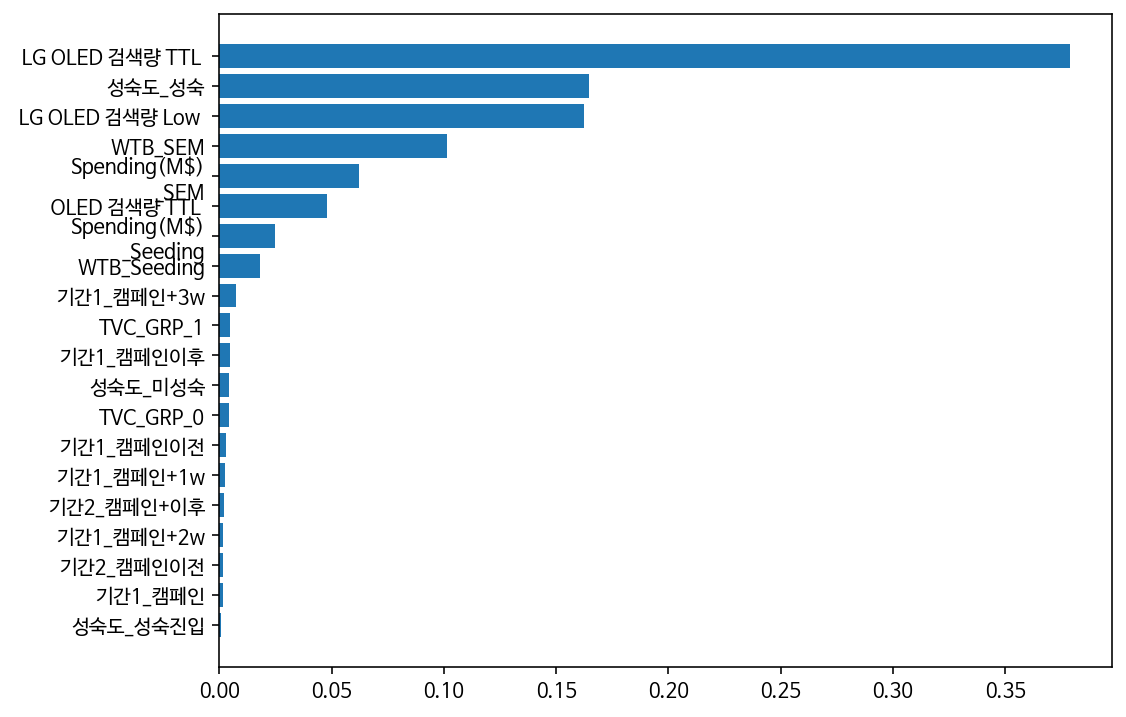

In [188]:
plot_feature_weight(X.columns, rfr.feature_importances_)

### 실제 데이타와 예측 데이타의 그래프 그리기
* 실제 결과 확인이 필요합니다. 
* 결과가 많아서 100개만 표시함

       Sell-out       predict
2015         258   841.450000
5569          90   144.480025
3801        1264  2242.100000
6504         370   474.200000
3571        1614  2186.160000
4630        1213  2254.290000
4588         206   345.580000
2536        1833  1977.470000
4498         830   478.450000
7135           9    95.401792


<function matplotlib.pyplot.show>

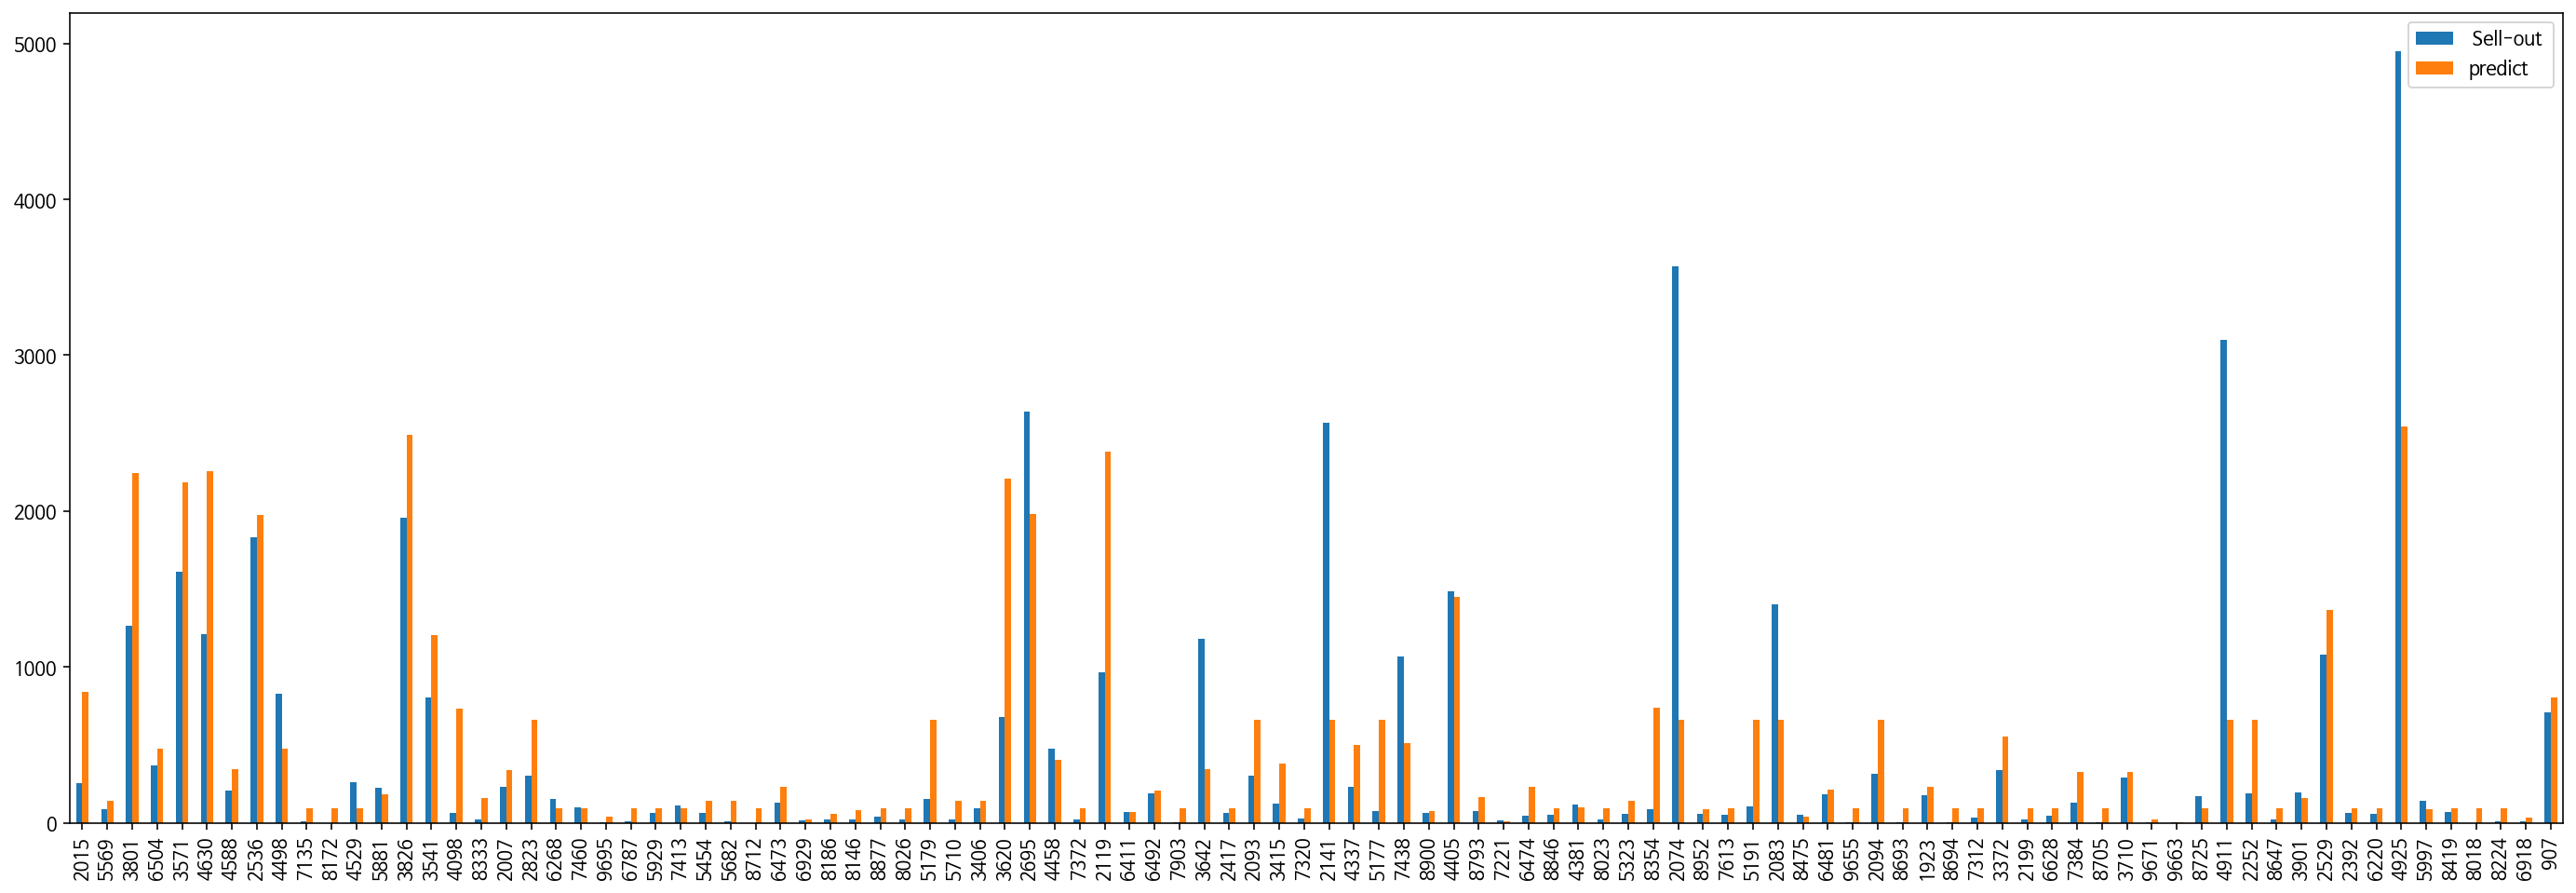

In [189]:
df4 = pd.DataFrame(y_test.copy())
df4['predict'] = y_pred.tolist()
#print(df4.shape)
#print(df4[:10])

# 100개만 출력 및 표시
print(df4[:10])
df4[:100].plot(kind='bar', figsize=(24,8))
#plt.xticks(rotation=45)
plt.show

In [190]:
print(X.shape)
print(X.index)
X2 = X.copy()
y2 = y.copy()

(7743, 20)
Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            9725, 9726, 9727, 9728, 9729, 9730, 9731, 9732, 9733, 9734],
           dtype='int64', length=7743)


## 추가 개선 
* 이상 데이타를 제외하고 처리하도록 개선합니다.

### 차이값이 큰 데이타들은 제외하고 처리한다 #1
* 차이가 1000 이상 제외

In [191]:
_df4 = df4[df4.loc[:, (' Sell-out ', 'predict')].apply(lambda x: np.abs(x[0] - x[1]) > 1000, axis=1)]
print(f'차이가 큰 데이타 수: {_df4.shape[0]}')
#print(_df4)
#print(_df4.index)

차이가 큰 데이타 수: 83


In [192]:
#print(X2.shape, y2.shape)
org_size = X2.shape[0]
#print(list(_df4.index))
X2 = X2.drop(list(_df4.index))
y2 = y2.drop(list(_df4.index))
#print(X2.shape, y2.shape)
#print(X2.index, y2.index)
print(f'삭제된 데이타 수: {org_size - X2.shape[0]}')

삭제된 데이타 수: 83


In [193]:
print(f'X:{X2.shape}')
print(f'y:{y2.shape}')

X_train, X_test, y_train, y_test = train_test_split(X2, y2)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

X:(7660, 20)
y:(7660,)
(5745, 20) (1915, 20) (5745,) (1915,)


In [194]:
rfr2 = RandomForestRegressor()
rfr2.fit(X_train, y_train)
y_pred = rfr2.predict(X_test)
#print(y_pred.shape, y_test.shape)
show_reg_result(y_test,y_pred)

Max Error:  11226.48
Mean Absolute Error:  212.15108
Root Mean Squared Error:  526.13629
R-Squared:  0.66403


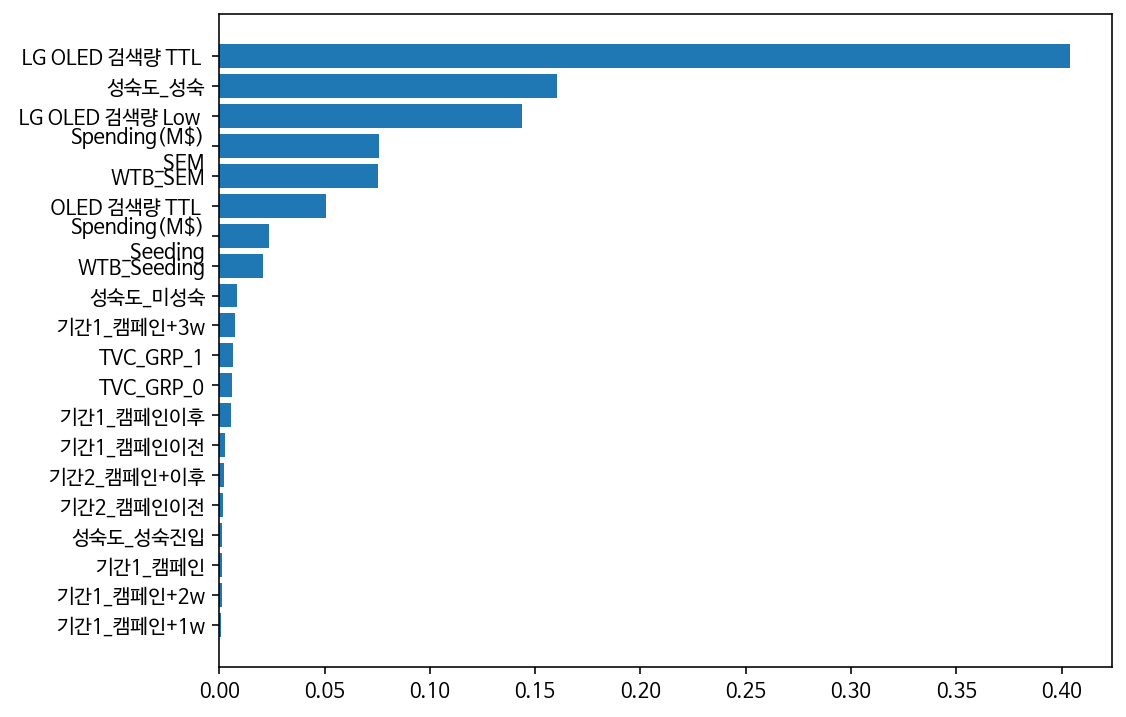

In [195]:
plot_feature_weight(X2.columns, rfr2.feature_importances_)

       Sell-out       predict
7418         108   196.420000
4787          90    92.783314
3324          99   263.579603
4253         384   384.840000
3598        1508   745.570000
2980         159    92.783314
5698          19   144.942917
6021         222   129.490000
2673        3127  1677.560000
8474          66   150.460000


<function matplotlib.pyplot.show>

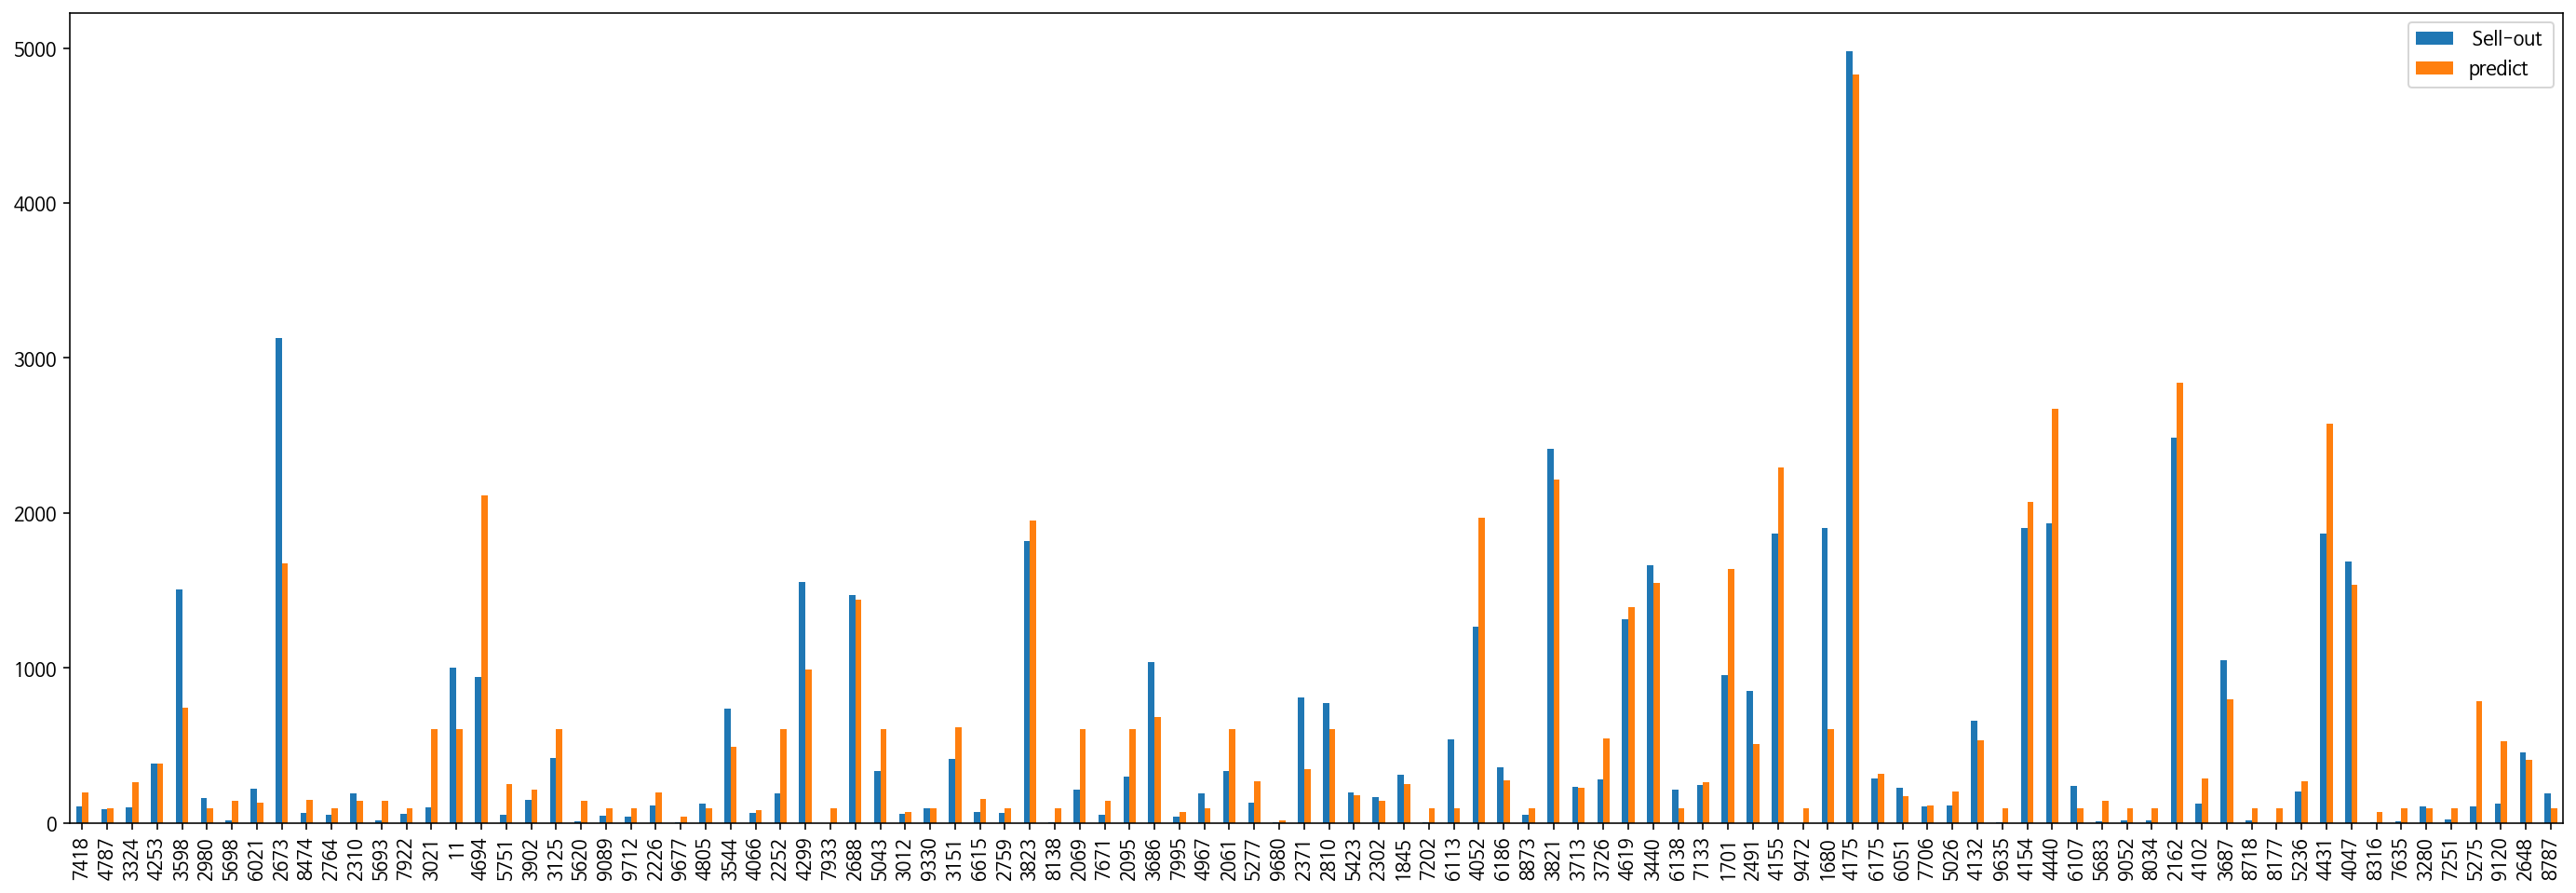

In [196]:
df4 = pd.DataFrame(y_test.copy())
df4['predict'] = y_pred.tolist()
#print(df4.shape)
#print(df4[:10])

# 100개만 출력 및 표시
print(df4[:10])
df4[:100].plot(kind='bar', figsize=(24,8))
#plt.xticks(rotation=45)
plt.show

### 차이값이 큰 데이타들은 제외하고 처리한다 #2
* 차이가 1000 이상 제외

In [197]:
_df4 = df4[df4.loc[:, (' Sell-out ', 'predict')].apply(lambda x: np.abs(x[0] - x[1]) > 1000, axis=1)]
print(f'차이가 큰 데이타 수: {_df4.shape[0]}')
#print(_df4)
#print(_df4.index)

차이가 큰 데이타 수: 70


In [198]:
#print(X2.shape, y2.shape)
org_size = X2.shape[0]
#print(list(_df4.index))
X2 = X2.drop(list(_df4.index))
y2 = y2.drop(list(_df4.index))
#print(X2.shape, y2.shape)
#print(X2.index, y2.index)
print(f'삭제된 데이타 수: {org_size - X2.shape[0]}')

삭제된 데이타 수: 70


In [199]:
print(f'X:{X2.shape}')
print(f'y:{y2.shape}')

X_train, X_test, y_train, y_test = train_test_split(X2, y2)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

X:(7590, 20)
y:(7590,)
(5692, 20) (1898, 20) (5692,) (1898,)


In [200]:
rfr2 = RandomForestRegressor()
rfr2.fit(X_train, y_train)
y_pred = rfr2.predict(X_test)
#print(y_pred.shape, y_test.shape)
show_reg_result(y_test,y_pred)

Max Error:  7407.51
Mean Absolute Error:  197.74803
Root Mean Squared Error:  453.46527
R-Squared:  0.64351


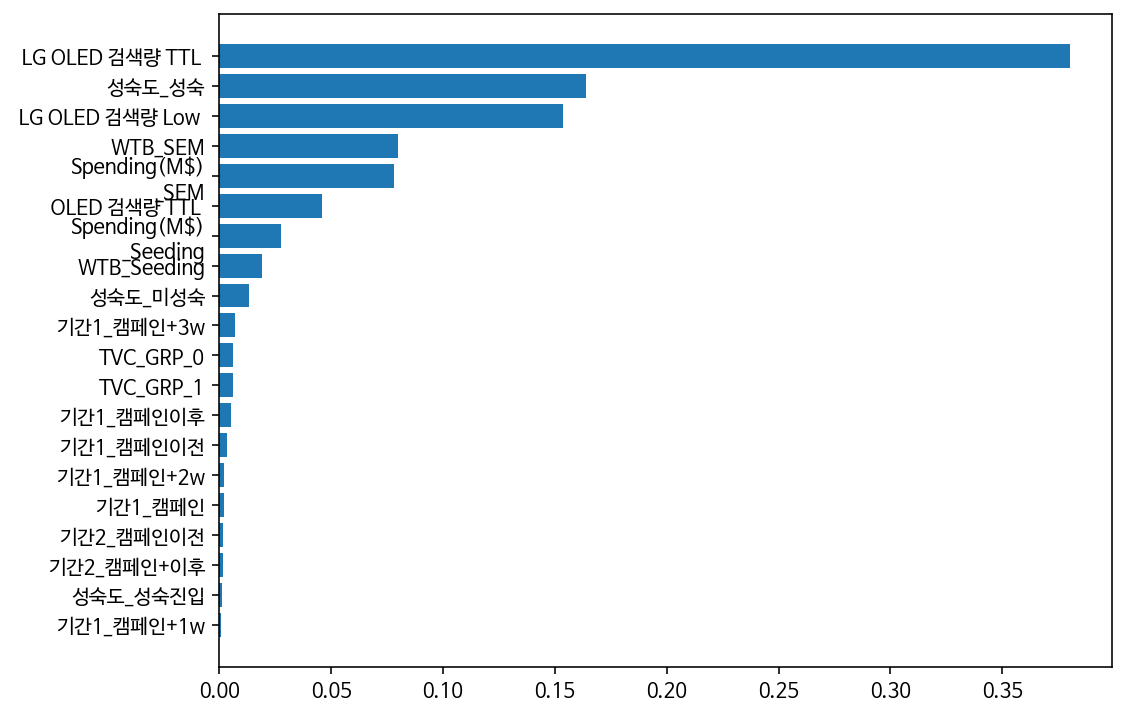

In [201]:
plot_feature_weight(X2.columns, rfr2.feature_importances_)

       Sell-out       predict
6741           1    87.768981
5577         212    96.423419
3024         139   578.909503
7250          33    87.768981
8673          33    87.768981
5970         198    87.768981
8850          49    87.768981
4270        1713  1105.460000
3445        1361  1454.265153
7489          91    87.768981


<function matplotlib.pyplot.show>

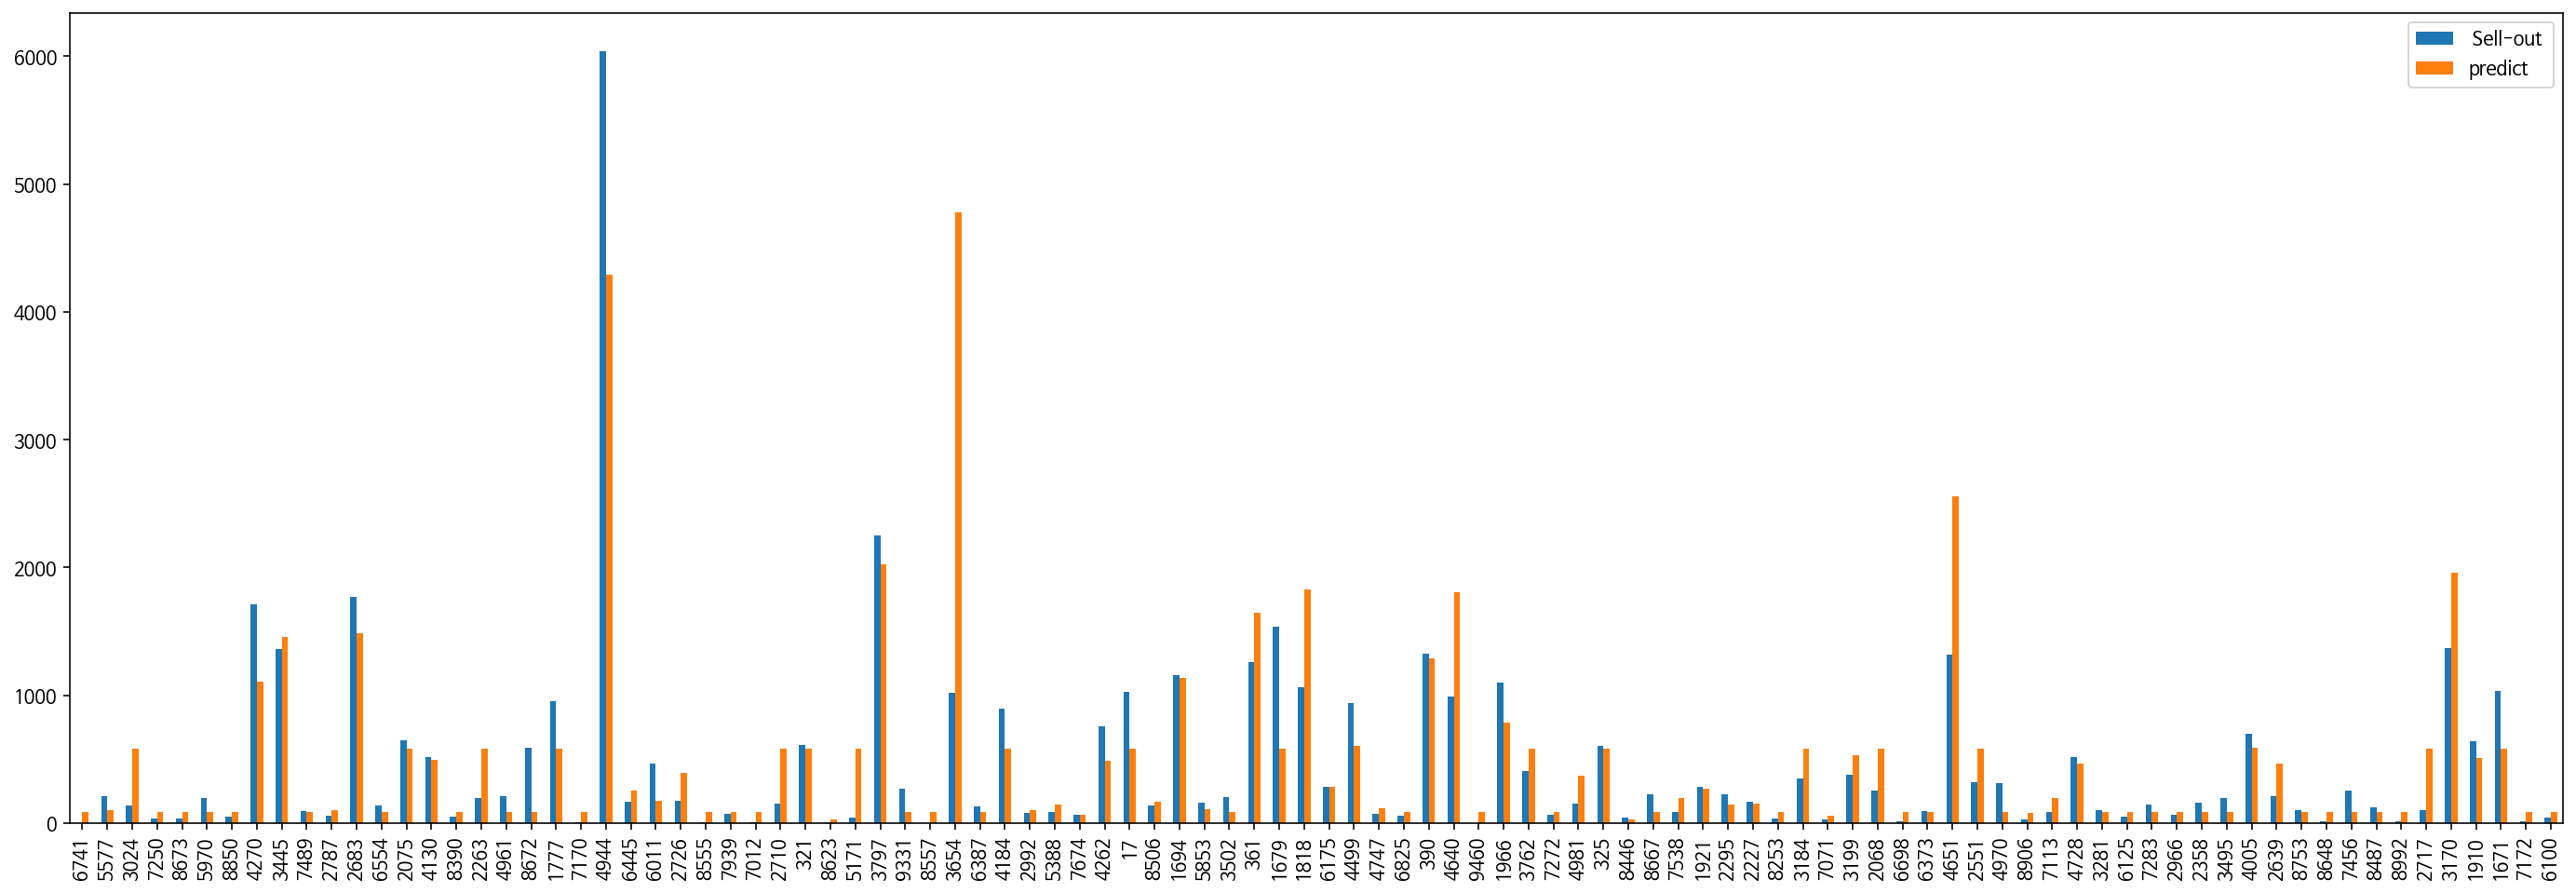

In [202]:
df4 = pd.DataFrame(y_test.copy())
df4['predict'] = y_pred.tolist()
#print(df4.shape)
#print(df4[:10])

# 100개만 출력 및 표시
print(df4[:10])
df4[:100].plot(kind='bar', figsize=(24,8))
#plt.xticks(rotation=45)
plt.show